# Synthetic Instructional Diagrams (Conditional Diffusion)

**Project:** Synthetic Data Creation: Survey and Synthesis  
**Method Group:** Perceptual and Media Synthesis  
**Sub-method:** Denoising Diffusion Probabilistic Models (DDPM)  
**Author:** Prajna Penmetsa

**Goal:** Synthesize **Instructional Geometry Diagrams** (Circles, Squares, Triangles) to train Vision-Language Models for education.
- **Method:** Uses a **Conditional DDPM** where a class label (e.g., "Triangle") is injected into the U-Net.
- **Utility:** Allows researchers to generate specific datasets (e.g., "Create 50 triangles and 10 squares") to fix class imbalances in training data.
- **Process:** Iterative denoising (300 timesteps) transforms pure noise into structured geometric shapes.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2  # OpenCV for drawing synthetic shapes

# --- CONFIGURATION ---
IMAGE_SIZE = 32     # Small size for faster training
CHANNELS = 1        # Grayscale (Diagrams are black & white)
TIMESTEPS = 300     # Number of diffusion steps (Noise -> Image)
BATCH_SIZE = 64
EPOCHS = 10         # Enough to see shapes emerge on these simple diagrams
LR = 1e-3
SEED = 42

# Setup Output Directory
OUTPUT_DIR = os.path.join("outputs", "diffusion_diagrams")
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Saving outputs to: {os.path.abspath(OUTPUT_DIR)}")

# Hardware Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

Saving outputs to: /Users/lakshmiprajnapenmetsa/Desktop/iiith/research/irel/synthetic-data-generation/Perceptual and Media Synthesis/Diffusion/outputs/diffusion_diagrams
Using device: cpu


Labels: ['Triangle', 'Circle', 'Circle', 'Square', 'Triangle', 'Triangle', 'Square', 'Circle']


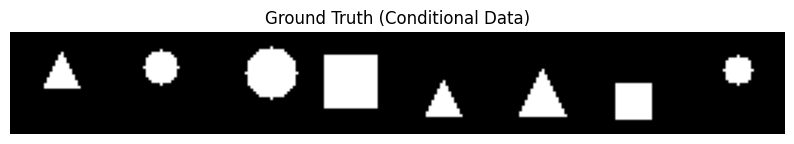

In [2]:
# Create a Custom Dataset of Geometric Diagrams
# Now returns BOTH the image and the label (0, 1, 2)

class ShapeDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=2000, img_size=32):
        self.num_samples = num_samples
        self.img_size = img_size
        self.data = []
        self.labels = []
        self._generate_shapes()

    def _generate_shapes(self):
        for _ in range(self.num_samples):
            img = np.zeros((self.img_size, self.img_size), dtype=np.uint8)
            
            # Label Mapping: 0=Circle, 1=Square, 2=Triangle
            shape_type = np.random.choice(['circle', 'square', 'triangle'])
            
            # Random Position & Size
            cx, cy = np.random.randint(8, 24, 2)
            size = np.random.randint(5, 10)
            
            label_idx = 0
            if shape_type == 'circle':
                cv2.circle(img, (cx, cy), size, 255, -1)
                label_idx = 0
            elif shape_type == 'square':
                x1, y1 = cx - size, cy - size
                x2, y2 = cx + size, cy + size
                cv2.rectangle(img, (x1, y1), (x2, y2), 255, -1)
                label_idx = 1
            elif shape_type == 'triangle':
                pts = np.array([[cx, cy-size], [cx-size, cy+size], [cx+size, cy+size]], np.int32)
                cv2.fillPoly(img, [pts], 255)
                label_idx = 2
            
            # Normalize to [-1, 1]
            img_tensor = torch.tensor(img, dtype=torch.float32) / 127.5 - 1.0
            
            self.data.append(img_tensor.unsqueeze(0))
            self.labels.append(label_idx)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Initialize
dataset = ShapeDataset(num_samples=2000, img_size=IMAGE_SIZE)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Visualize with Labels
real_imgs, real_labels = next(iter(dataloader))
mapping = {0: 'Circle', 1: 'Square', 2: 'Triangle'}

plt.figure(figsize=(10, 2))
plt.title("Ground Truth (Conditional Data)")
grid_img = torchvision.utils.make_grid(real_imgs[:8], nrow=8, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
print("Labels:", [mapping[l.item()] for l in real_labels[:8]])
plt.axis("off")
plt.show()

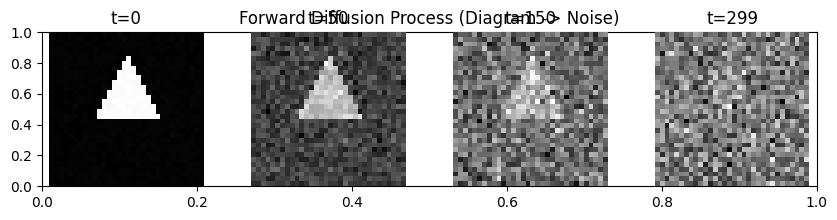

In [3]:
# --- DIFFUSION UTILITIES ---
# Define the "Forward Process" (Adding Noise)

# Pre-calculate noise schedule (Linear Beta Schedule)
betas = torch.linspace(1e-4, 0.02, TIMESTEPS).to(device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# Calculations for adding noise (q_sample)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image (x_0) and a timestep (t) and returns the noisy version.
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t][:, None, None, None]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
    
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

# Visualize the Forward Process
# Shows how a diagram turns into pure noise
sample_img = real_imgs[0].unsqueeze(0).to(device)
plt.figure(figsize=(10, 2))
plt.title("Forward Diffusion Process (Diagram -> Noise)")

for i, step in enumerate([0, 50, 150, 299]):
    t = torch.tensor([step], device=device)
    noisy_img, _ = forward_diffusion_sample(sample_img, t, device)
    
    plt.subplot(1, 4, i+1)
    plt.imshow(noisy_img.detach().cpu().squeeze(), cmap='gray')
    plt.axis("off")
    plt.title(f"t={step}")
plt.show()

In [4]:
# --- CONDITIONAL U-NET MODEL ---
# Now accepts 'labels' to guide the generation.

class ConditionalUNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        
        # 1. Label Embedding (The "Condition")
        # Maps label (0,1,2) to a vector of size 32
        self.label_emb = nn.Embedding(num_classes, 32)
        
        # 2. Time Embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        
        # Encoder
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        
        self.mid = nn.Conv2d(128, 128, 3, padding=1)
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.up2 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.out = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x, t, labels):
        # Embed Time
        t = t.float().view(-1, 1)
        t_emb = self.time_mlp(t)
        
        # Embed Label
        l_emb = self.label_emb(labels)
        
        # Combine Condition (Time + Label)
        # We merge them so the model knows "At time T, draw a Triangle"
        cond = t_emb + l_emb
        cond = cond.view(-1, 32, 1, 1) # Broadcast to image dims
        
        # Pass through U-Net
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1 + cond)) # Inject Condition here!
        x3 = F.relu(self.conv3(x2))
        
        mid = F.relu(self.mid(x3))
        
        up1 = F.relu(self.up1(mid)) 
        up2 = F.relu(self.up2(up1 + x2))
        
        return self.out(up2)

model = ConditionalUNet(num_classes=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

print("Conditional Diffusion U-Net Initialized.")

Conditional Diffusion U-Net Initialized.


In [5]:
# Train the Conditional Model
print("Starting Training...")
loss_history = []

for epoch in range(EPOCHS):
    for step, (images, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        
        images = images.to(device)
        labels = labels.to(device) # Move labels to GPU
        t = torch.randint(0, TIMESTEPS, (images.shape[0],), device=device).long()
        
        # 1. Add Noise
        noisy_images, noise = forward_diffusion_sample(images, t, device)
        
        # 2. Predict Noise (Conditioned on Label)
        noise_pred = model(noisy_images, t, labels)
        
        # 3. Loss
        loss = loss_fn(noise_pred, noise)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch}: Loss {loss.item():.4f}")
    loss_history.append(loss.item())

# Save
torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "cond_diffusion.pth"))

plt.plot(loss_history)
plt.title("Conditional Diffusion Training Loss")
plt.show()

Starting Training...


KeyboardInterrupt: 

In [ ]:
# --- THE RESEARCHER FRAMEWORK ---

@torch.no_grad()
def simulate_diagram_set(request_dict):
    """
    Generates specific diagrams based on a researcher's request.
    Example: {'triangle': 5, 'circle': 3}
    """
    model.eval()
    mapping = {'circle': 0, 'square': 1, 'triangle': 2}
    
    generated_images = []
    generated_labels = []
    
    print(f"--- Simulating Diagram Set ---")
    
    for shape_name, count in request_dict.items():
        if count == 0: continue
        label_idx = mapping[shape_name]
        print(f"   -> Diffusing {count} '{shape_name}' diagrams...")
        
        # 1. Start with Noise
        x = torch.randn((count, 1, IMAGE_SIZE, IMAGE_SIZE)).to(device)
        
        # 2. Create Label Tensor (e.g., all 2s for triangles)
        labels = torch.full((count,), label_idx, device=device, dtype=torch.long)
        
        # 3. Iteratively Denoise (Guided by Label)
        for i in reversed(range(TIMESTEPS)):
            t = torch.full((count,), i, device=device, dtype=torch.long)
            
            predicted_noise = model(x, t, labels)
            
            alpha = alphas[i]
            alpha_hat = alphas_cumprod[i]
            beta = betas[i]
            
            if i > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
                
            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
            
        generated_images.append(x)
        generated_labels.extend([shape_name] * count)
        
    return torch.cat(generated_images), generated_labels

# ==========================================
# USER SCENARIOS (The Researcher's Request)
# ==========================================

# Request: "I need a training set with mostly Triangles and Squares, no Circles."
diag_tensor, diag_names = simulate_diagram_set({
    'triangle': 10,
    'square': 10,
    'circle': 0
})

# --- VISUALIZATION ---
plt.figure(figsize=(12, 6))
plt.title("Scenario Output: Triangles & Squares Only")
grid_img = torchvision.utils.make_grid(diag_tensor.cpu(), nrow=10, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
plt.axis("off")

# Save
save_path = os.path.join(OUTPUT_DIR, "scenario_triangles_squares.png")
plt.savefig(save_path)
print(f"Saved simulation to: {save_path}")
plt.show()